In [20]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
NROWS = 2000

In [21]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

In [25]:
trades = pd.read_csv(PATH_TO_FILE+'trades.csv', nrows=100000)

In [26]:
trades.head(20)

,receive_ts,exchange_ts,aggro_side,price,size
0,1655942402624789714,1655942402623000000,BID,19977.5,0.001
1,1655942405293556247,1655942405292000000,BID,19977.5,0.041
2,1655942405293628020,1655942405292000000,BID,19977.5,0.036
3,1655942405293832021,1655942405292000000,BID,19977.5,0.001
4,1655942405293929517,1655942405292000000,BID,19977.5,0.001
5,1655942405294003345,1655942405292000000,BID,19977.8,0.003
6,1655942405294140676,1655942405292000000,BID,19977.9,0.003
7,1655942405294206928,1655942405292000000,BID,19978.0,0.001
8,1655942408891268324,1655942408890000000,ASK,19977.9,0.020
9,1655942409197011118,1655942409193000000,BID,19978.0,0.058


In [27]:
len(set(trades.exchange_ts))

35350

In [28]:
len(set(trades.receive_ts))

100000

In [29]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

In [30]:
#delay between orders
delay = pd.Timedelta(0.1, 's').delta

hold_time = pd.Timedelta(10, 's').delta

strategy = BestPosStrategy(delay, hold_time)

In [31]:
trades_list, md_list, updates_list = strategy.run(sim)

In [32]:
df = get_pnl(updates_list)

In [33]:
dt = pd.to_datetime(df.receive_ts)

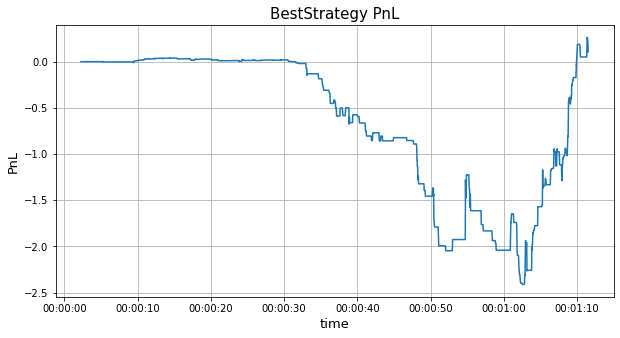

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()

In [1]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import merge_books_and_trades


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from simulator import MdUpdate, OrderbookSnapshotUpdate, AnonTrade

from get_info import md_to_dataframe, trade_to_dataframe

In [19]:
def generate_sample_data_1(n_points):
    mid_price = 100.0
    spread = 2.0
    bid_price = mid_price - spread / 2
    ask_price = mid_price + spread / 2
    size = 1
    
    books = [OrderbookSnapshotUpdate(2 * i, 2 * i, [(ask_price, size)], [(bid_price, size)]) for i in range(1) ]
    
    trades = []
    p = 0.25
    trade_id = np.random.choice([0, 1], size=n_points, p=[1-p, p])
    trade_id = [i % 5 == 0 for i in range(n_points)]
    for i in range(n_points):
        
        if trade_id[i]:
            
            side = np.random.choice([0, 1], size=1)[0]
            price = bid_price if side else ask_price
            side = "ASK" if side else "BID" 
            trade = AnonTrade(2 * i + 1, 2 * i + 1, side, size, price)
            trades.append(trade)

    return books, trades

In [20]:
def generate_sample_data_2(n_points):
    
    mid_price = 100.0
    spread = 2.0
    bid_price = mid_price - spread / 2
    ask_price = mid_price + spread / 2
    size = 1
    
    books = []
    
    
    trades = []
    p = 0.5
    for i in range(n_points):
        
        bid_price = mid_price - spread / 2
        ask_price = mid_price + spread / 2
        
        book = OrderbookSnapshotUpdate(i, i, [(ask_price, size)], [(bid_price, size)])
        books.append( book  )
        mid_price += 1
    return books, trades

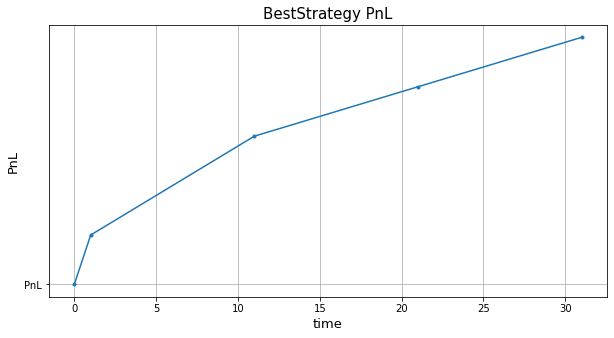

In [35]:
books, anon_trades = generate_sample_data_1(16)

md = merge_books_and_trades(books, anon_trades)

latency = pd.Timedelta(0, 'ns').delta
md_latency = pd.Timedelta(0, 'ns').delta
sim = Sim(md, latency, md_latency)

#delay between orders
delay = pd.Timedelta(1, 'ns').delta
hold_time = pd.Timedelta(1000, 'ns').delta
strategy = BestPosStrategy(delay, hold_time)

own_trades, md_list, updates_list, all_orders = strategy.run(sim)

df_info = get_pnl(updates_list)
t = df_info.receive_ts.values

plt.figure(figsize=(10, 5))
plt.plot(t, df_info.total, '.-', 'PnL')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)

plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()

In [36]:
updates_list

[MdUpdate(exchange_ts=0, receive_ts=0, orderbook=OrderbookSnapshotUpdate(exchange_ts=0, receive_ts=0, asks=[(101.0, 1)], bids=[(99.0, 1)]), trade=None),
 MdUpdate(exchange_ts=1, receive_ts=1, orderbook=None, trade=AnonTrade(exchange_ts=1, receive_ts=1, side='BID', size=1, price=101.0)),
 OwnTrade(place_ts=0, exchange_ts=1, receive_ts=1, trade_id=0, order_id=1, side='ASK', size=0.001, price=101.0, execute='TRADE'),
 MdUpdate(exchange_ts=11, receive_ts=11, orderbook=None, trade=AnonTrade(exchange_ts=11, receive_ts=11, side='ASK', size=1, price=99.0)),
 OwnTrade(place_ts=0, exchange_ts=11, receive_ts=11, trade_id=1, order_id=0, side='BID', size=0.001, price=99.0, execute='TRADE'),
 OwnTrade(place_ts=1, exchange_ts=11, receive_ts=11, trade_id=2, order_id=2, side='BID', size=0.001, price=99.0, execute='TRADE'),
 MdUpdate(exchange_ts=21, receive_ts=21, orderbook=None, trade=AnonTrade(exchange_ts=21, receive_ts=21, side='ASK', size=1, price=99.0)),
 OwnTrade(place_ts=11, exchange_ts=21, recei

In [37]:
all_orders

[Order(place_ts=0, exchange_ts=0, order_id=0, side='BID', size=0.001, price=99.0),
 Order(place_ts=0, exchange_ts=0, order_id=1, side='ASK', size=0.001, price=101.0),
 Order(place_ts=1, exchange_ts=1, order_id=2, side='BID', size=0.001, price=99.0),
 Order(place_ts=1, exchange_ts=1, order_id=3, side='ASK', size=0.001, price=101.0),
 Order(place_ts=11, exchange_ts=11, order_id=4, side='BID', size=0.001, price=99.0),
 Order(place_ts=11, exchange_ts=11, order_id=5, side='ASK', size=0.001, price=101.0),
 Order(place_ts=21, exchange_ts=21, order_id=6, side='BID', size=0.001, price=99.0),
 Order(place_ts=21, exchange_ts=21, order_id=7, side='ASK', size=0.001, price=101.0),
 Order(place_ts=31, exchange_ts=31, order_id=8, side='BID', size=0.001, price=99.0),
 Order(place_ts=31, exchange_ts=31, order_id=9, side='ASK', size=0.001, price=101.0)]

In [38]:
sim.ready_to_execute_orders

{3: Order(place_ts=1, exchange_ts=1, order_id=3, side='ASK', size=0.001, price=101.0),
 5: Order(place_ts=11, exchange_ts=11, order_id=5, side='ASK', size=0.001, price=101.0),
 7: Order(place_ts=21, exchange_ts=21, order_id=7, side='ASK', size=0.001, price=101.0),
 8: Order(place_ts=31, exchange_ts=31, order_id=8, side='BID', size=0.001, price=99.0),
 9: Order(place_ts=31, exchange_ts=31, order_id=9, side='ASK', size=0.001, price=101.0)}

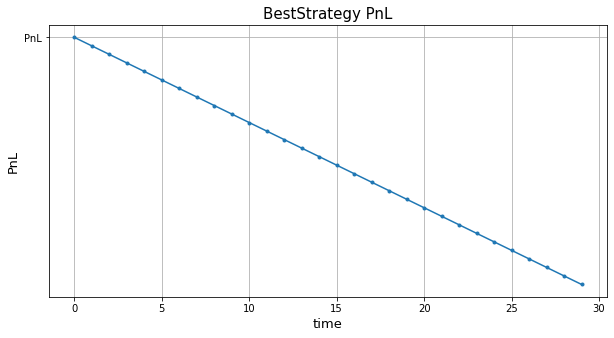

In [37]:
books, anon_trades = generate_sample_data_2(30)

md = merge_books_and_trades(books, anon_trades)

latency = pd.Timedelta(1, 'ns').delta
md_latency = pd.Timedelta(0, 'ns').delta
sim = Sim(md, latency, md_latency)

#delay between orders
delay = pd.Timedelta(0, 'ns').delta
hold_time = pd.Timedelta(1000, 'ns').delta
strategy = BestPosStrategy(delay, hold_time)

own_trades, md_list, updates_list, all_orders = strategy.run(sim)

df_info = get_pnl(updates_list)
t = df_info.receive_ts.values

plt.figure(figsize=(10, 5))
plt.plot(t, df_info.BTC, '.-', 'PnL')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)

plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()